<a href="https://colab.research.google.com/github/mikenamo/learningsql-2875059/blob/main/RQ2_TikTok_vs_Spotify_lyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Colab cwd recovery + fresh clone + sanity checks ---

import os, shutil, subprocess, sys

def safe_chdir(path):
    try:
        os.chdir(path)
    except Exception as e:
        print(f"[warn] chdir to {path} failed: {e}")

# 1) hard reset to a known-good location
safe_chdir("/")
safe_chdir("/content")
print("[info] cwd now:", os.getcwd())

REPO_URL = "https://github.com/ShannonBonilla/COMM557_Project.git"
REPO_DIR = "/content/COMM557_Project"

# 2) remove any half-broken clone
shutil.rmtree(REPO_DIR, ignore_errors=True)

# 3) fresh clone
print("[info] cloning repo...")
rc = subprocess.call(["git", "clone", REPO_URL, REPO_DIR])
if rc != 0:
    raise RuntimeError("git clone failed; check your internet or repo URL")

# 4) move into repo (now that it exists)
safe_chdir(REPO_DIR)
print("[info] in repo:", os.getcwd())

# 5) print quick tree
print("\n[info] top-level files:")
os.system("ls -lah | sed -n '1,80p'")

print("\n[info] data/ folder:")
os.system("ls -lah data | sed -n '1,120p'")

# 6) define paths for later cells
ROOT = REPO_DIR
DATA = os.path.join(REPO_DIR, "data")
print("\n[ok] ROOT:", ROOT)
print("[ok] DATA:", DATA)



[info] cwd now: /content
[info] cloning repo...
[info] in repo: /content/COMM557_Project

[info] top-level files:

[info] data/ folder:

[ok] ROOT: /content/COMM557_Project
[ok] DATA: /content/COMM557_Project/data


In [2]:
from pathlib import Path
import pandas as pd, numpy as np, re, unicodedata, ast, os

DATA = Path("data")

def norm_cols(df):
    df.columns = [str(c).strip().lower().replace(" ", "_") for c in df.columns]
    return df

def safe_lower_ascii(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    return s.strip().lower()

def canon_title(raw: str) -> str:
    s = safe_lower_ascii(raw)
    s = re.sub(r"\s*\((feat[^)]*)\)", "", s)
    s = re.sub(r"\s*-\s*(remaster(?:ed)?(?:\s*\d{2,4})?|radio edit|single version|album version|clean|explicit|live|bonus track)\s*$","", s)
    s = s.replace("&", " and ")
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    if not s:
        s = safe_lower_ascii(raw)
        s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_artist_field(raw) -> list[str]:
    if raw is None or (isinstance(raw, float) and pd.isna(raw)): return []
    text = str(raw).strip()
    if text.startswith("[") and text.endswith("]"):
        try:
            vals = ast.literal_eval(text)
            if isinstance(vals,(list,tuple)):
                return [str(v).strip() for v in vals if str(v).strip()]
        except Exception:
            pass
    t = safe_lower_ascii(text)
    t = re.sub(r"\s+feat\.?\s+"," , ", t)
    t = re.sub(r"\s+featuring\s+"," , ", t)
    t = re.sub(r"\s+with\s+"," , ", t)
    t = re.sub(r"\s+and\s+"," , ", t)
    t = re.sub(r"\s*&\s*"," , ", t)
    t = re.sub(r"\s+x\s+"," , ", t)
    t = t.replace("/", " , ").replace(";", " , ")
    parts = [p.strip() for p in t.split(",") if p.strip()]
    return parts if parts else ([t] if t else [])

def canon_artist(raw: str) -> str:
    names = parse_artist_field(raw)
    primary = names[0] if names else ""
    primary = re.sub(r"[^a-z0-9\s]+"," ", primary)
    primary = re.sub(r"\s+"," ", primary).strip()
    return primary

def add_key_with_canon(df: pd.DataFrame, title_col="title", artist_col="artist") -> pd.DataFrame:
    if title_col not in df.columns or artist_col not in df.columns:
        raise ValueError("Need title/artist columns to build canonical keys.")
    df["title_canon"]  = df[title_col].map(canon_title)
    df["artist_canon"] = df[artist_col].map(canon_artist)
    df["key_canon"]    = df["title_canon"] + " // " + df["artist_canon"]
    bad = (df["title_canon"] == "") | (df["artist_canon"] == "")
    if bad.any(): df = df.loc[~bad].copy()
    return df


In [3]:
# --- Step 2 (robust): build TikTok/Spotify membership with per-file column detection ---
from pathlib import Path
import pandas as pd, os, re, unicodedata, ast

DATA = Path("data")

# File lists
tiktok_files  = sorted([f for f in os.listdir(DATA) if re.match(r"(?i)TikTok_songs_\d{4}\.csv", f)])
spotify_files = sorted([f for f in os.listdir(DATA) if re.match(r"(?i)spotify_top_charts_\d{2}\.csv", f)])

# ----- utilities you already defined earlier -----
def norm_cols(df):
    df.columns = [str(c).strip().lower().replace(" ", "_") for c in df.columns]
    return df

def safe_lower_ascii(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    return s.strip().lower()

def canon_title(raw: str) -> str:
    s = safe_lower_ascii(raw)
    s = re.sub(r"\s*\((feat[^)]*)\)", "", s)
    s = re.sub(r"\s*-\s*(remaster(?:ed)?(?:\s*\d{2,4})?|radio edit|single version|album version|clean|explicit|live|bonus track)\s*$", "", s)
    s = s.replace("&", " and ")
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    if not s:
        s = safe_lower_ascii(raw)
        s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_artist_field(raw) -> list[str]:
    if raw is None or (isinstance(raw, float) and pd.isna(raw)): return []
    text = str(raw).strip()
    if text.startswith("[") and text.endswith("]"):
        try:
            vals = ast.literal_eval(text)
            if isinstance(vals,(list,tuple)):
                return [str(v).strip() for v in vals if str(v).strip()]
        except Exception:
            pass
    t = safe_lower_ascii(text)
    t = re.sub(r"\s+feat\.?\s+"," , ", t)
    t = re.sub(r"\s+featuring\s+"," , ", t)
    t = re.sub(r"\s+with\s+"," , ", t)
    t = re.sub(r"\s+and\s+"," , ", t)
    t = re.sub(r"\s*&\s*"," , ", t)
    t = re.sub(r"\s+x\s+"," , ", t)
    t = t.replace("/", " , ").replace(";", " , ")
    parts = [p.strip() for p in t.split(",") if p.strip()]
    return parts if parts else ([t] if t else [])

def canon_artist(raw: str) -> str:
    names = parse_artist_field(raw)
    primary = names[0] if names else ""
    primary = re.sub(r"[^a-z0-9\s]+"," ", primary)
    primary = re.sub(r"\s+"," ", primary).strip()
    return primary

def add_key_with_canon(df: pd.DataFrame, title_col="title", artist_col="artist") -> pd.DataFrame:
    if title_col not in df.columns or artist_col not in df.columns:
        raise ValueError("Need title/artist columns to build canonical keys.")
    df["title_canon"]  = df[title_col].map(canon_title)
    df["artist_canon"] = df[artist_col].map(canon_artist)
    df["key_canon"]    = df["title_canon"] + " // " + df["artist_canon"]
    bad = (df["title_canon"] == "") | (df["artist_canon"] == "")
    if bad.any(): df = df.loc[~bad].copy()
    return df

# ----- NEW: per-file column detector with smart fallbacks -----
TITLE_CANDS  = {"title","track","track_name","track_title","song","song_title","name"}
ARTIST_CANDS = {"artist","artists","artist_name","artist_names","primary_artist","performer","singer","band"}

def detect_title_artist_cols(df: pd.DataFrame, file_label: str):
    """
    Returns (title_col, artist_col). Tries:
      1) direct matches from TITLE_CANDS / ARTIST_CANDS
      2) suffix matches (e.g., '*track_name', '*artist_name')
      3) parse from a single text column 'Title - Artist' or 'Title by Artist'
      4) Spotify-style combined columns like 'track__artists' -> split list
    Raises ValueError with diagnostics if still not found.
    """
    df = norm_cols(df.copy())
    cols = list(df.columns)

    # direct
    title_col  = next((c for c in cols if c in TITLE_CANDS), None)
    artist_col = next((c for c in cols if c in ARTIST_CANDS), None)

    # suffix/prefixed variants
    if title_col is None:
        title_col = next((c for c in cols if c.endswith("track_name") or c.endswith("track") or c.endswith("song") or c.endswith("title")), None)
    if artist_col is None:
        artist_col = next((c for c in cols if c.endswith("artist_name") or c.endswith("artists") or c.endswith("artist")), None)

    # spotify export quirks (sometimes nested names)
    if artist_col is None:
        artist_col = next((c for c in cols if "artist" in c), None)
    if title_col is None:
        title_col = next((c for c in cols if "track" in c or "song" in c or "title" in c), None)

    # parse from single long text col
    def try_parse(series: pd.Series):
        s = series.astype(str)
        if s.str.contains(" - ").any():
            parts = s.str.split(" - ", n=1, expand=True)
            if parts.shape[1] == 2: return parts[0], parts[1]
        if s.str.contains(r"\s+by\s+", regex=True).any():
            parts = s.str.split(r"\s+by\s+", n=1, expand=True, regex=True)
            if parts.shape[1] == 2: return parts[0], parts[1]
        return None, None

    parsed_cols = False
    if title_col is None or artist_col is None:
        text_cols = [c for c in cols if df[c].dtype == object]
        for c in text_cols:
            if df[c].notna().any():
                t_guess, a_guess = try_parse(df[c].dropna())
                if t_guess is not None:
                    df["__title_guess"]  = t_guess
                    df["__artist_guess"] = a_guess
                    title_col, artist_col = "__title_guess", "__artist_guess"
                    parsed_cols = True
                    break

    if title_col is None or artist_col is None:
        raise ValueError(f"[diag] Could not map title/artist for {file_label}. Columns: {cols}")

    # If artist column looks like a list, leave it—we handle in canon_artist()
    return df, title_col, artist_col

def build_keys(files, label):
    keys, dropped_total = set(), 0
    for fname in files:
        p = DATA / fname
        df_raw = pd.read_csv(p)
        df_map, tcol, acol = detect_title_artist_cols(df_raw, f"{label}:{fname}")
        before = len(df_map)
        df2 = add_key_with_canon(df_map, tcol, acol)
        dropped_total += (before - len(df2))
        keys |= set(df2["key_canon"])
    if dropped_total:
        print(f"[{label}] Dropped {dropped_total} rows with empty title/artist after cleaning.")
    return keys

# ---- Build sets now
tik_keys = build_keys(tiktok_files, "TikTok")
sp_keys  = build_keys(spotify_files, "Spotify")

TIKTOK_CROSSOVER = frozenset(sp_keys & tik_keys)
SPOTIFY_ONLY     = frozenset(sp_keys - tik_keys)

print("TikTok files:", tiktok_files)
print("Spotify files:", spotify_files)
print(f"Counts -> TikTok set: {len(tik_keys)} | Spotify set: {len(sp_keys)}")
print(f"Groups -> Crossover: {len(TIKTOK_CROSSOVER)} | Spotify-only: {len(SPOTIFY_ONLY)}")
print("Sample Spotify-only:", list(sorted(SPOTIFY_ONLY))[:10])



[TikTok] Dropped 4 rows with empty title/artist after cleaning.
TikTok files: ['TikTok_songs_2019.csv', 'TikTok_songs_2020.csv', 'TikTok_songs_2021.csv', 'TikTok_songs_2022.csv']
Spotify files: ['spotify_top_charts_19.csv', 'spotify_top_charts_20.csv', 'spotify_top_charts_21.csv', 'spotify_top_charts_22.csv']
Counts -> TikTok set: 811 | Spotify set: 3071
Groups -> Crossover: 260 | Spotify-only: 2811
Sample Spotify-only: ['! // trippie redd', '00 00 zero oclock // bts', '0x1 lovesong i know i love you feat seori // tomorrow', '1 0 0 m i l with bas // j cole', '1 step forward 3 steps back // olivia rodrigo', '10 000 hours with justin bieber // dan shay', '10 freaky girls with 21 savage // metro boomin', '10 things i hate about you // leah kate', '10 years // dai freyr', '1000 doves // lady gaga']


In [4]:
# Replace with your exact repo path if different
%cd /content/COMM557_Project

# Download the CSV from GitHub raw into your data/ folder (overwrites if present)
!curl -L -o data/dataset_with_topics.csv \
  "https://raw.githubusercontent.com/ShannonBonilla/COMM557_Project/refs/heads/main/data/dataset_with_topics.csv"


/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7933k  100 7933k    0     0  12.2M      0 --:--:-- --:--:-- --:--:-- 12.2M


In [5]:
import pandas as pd

topics_path = "/content/COMM557_Project/data/dataset_with_topics.csv"
df = pd.read_csv(topics_path)
print(df.shape)
print(df.columns[:15].tolist())
df.head(2)





(3357, 19)
['track_name', 'artist_name', 'danceability', 'energy', 'loudness', 'mode', 'key', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'time_signature', 'duration_ms', 'source']


,track_name,artist_name,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,duration_ms,source,lyrics,lyrics_missing,topic_number,topic_label
0,Wow.,Post Malone,833.0,539.0,"-7,399",0,11,178.0000,163.00,0.000002,101.0,"99,947",4,149520,spotify,"Said she tired of little money, need a big boy...",False,2.0,Boastful Rap Themes
1,"thank u, next",Ariana Grande,724.0,647.0,"-5,642",1,1,0.0658,0.28,0.000000,102.0,106.96,4,207333,spotify,Thought I'd end up with Sean\nBut he wasn't a ...,False,0.0,Love & Life Themes


In [6]:
# --- Step 3: use topic_number/topic_label (no probs needed) ---

import pandas as pd, numpy as np, re, unicodedata, ast

topics_path = "/content/COMM557_Project/data/dataset_with_topics.csv"

def norm_cols(df):
    df.columns = [str(c).strip().lower().replace(" ", "_") for c in df.columns]
    return df

def safe_lower_ascii(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    return s.strip().lower()

def canon_title(raw: str) -> str:
    s = safe_lower_ascii(raw)
    s = re.sub(r"\s*\((feat[^)]*)\)", "", s)
    s = re.sub(r"\s*-\s*(remaster(?:ed)?(?:\s*\d{2,4})?|radio edit|single version|album version|clean|explicit|live|bonus track)\s*$","", s)
    s = s.replace("&", " and ")
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s or re.sub(r"\s+"," ", safe_lower_ascii(raw)).strip()

def parse_artist_field(raw):
    if raw is None or (isinstance(raw, float) and pd.isna(raw)): return []
    text = str(raw).strip()
    if text.startswith("[") and text.endswith("]"):
        try:
            vals = ast.literal_eval(text)
            if isinstance(vals,(list,tuple)):
                return [str(v).strip() for v in vals if str(v).strip()]
        except: pass
    t = safe_lower_ascii(text)
    for pat in [r"\s+feat\.?\s+", r"\s+featuring\s+", r"\s+with\s+", r"\s+and\s+", r"\s*&\s*", r"\s+x\s+"]:
        t = re.sub(pat, " , ", t)
    t = t.replace("/", " , ").replace(";", " , ")
    parts = [p.strip() for p in t.split(",") if p.strip()]
    return parts if parts else ([t] if t else [])

def canon_artist(raw):
    names = parse_artist_field(raw); primary = names[0] if names else ""
    primary = re.sub(r"[^a-z0-9\s]+", " ", primary); primary = re.sub(r"\s+"," ", primary).strip()
    return primary

def add_key_canon_from_cols(df, tcol, acol):
    df["title_canon"]  = df[tcol].map(canon_title)
    df["artist_canon"] = df[acol].map(canon_artist)
    df["key"]          = df["title_canon"] + " // " + df["artist_canon"]
    bad = (df["title_canon"] == "") | (df["artist_canon"] == "")
    return df.loc[~bad].copy()

# load & normalize
topics = pd.read_csv(topics_path)
topics = norm_cols(topics)

# choose topic column: prefer topic_number; fallback to label digits
if "topic_number" in topics.columns:
    topics["topic"] = pd.to_numeric(topics["topic_number"], errors="coerce").astype("Int64")
elif "topic_label" in topics.columns:
    s = topics["topic_label"].astype(str).str.extract(r"(\d+)").squeeze()
    topics["topic"] = pd.to_numeric(s, errors="coerce").astype("Int64")
else:
    raise ValueError("No 'topic_number' or 'topic_label' column found in topics file.")

# standardize title/artist -> canonical key
tcol = "track_name" if "track_name" in topics.columns else "title"
acol = "artist_name" if "artist_name" in topics.columns else "artist"
if tcol not in topics.columns or acol not in topics.columns:
    raise ValueError("Expected 'track_name'/'artist_name' (or 'title'/'artist') in topics file.")
topics = add_key_canon_from_cols(topics, tcol, acol)

# keep one row per key and valid topic
topics = topics.dropna(subset=["topic"]).copy()
topics["topic"] = topics["topic"].astype(int)
topics = topics.drop_duplicates(subset=["key"], keep="first").copy()

print("topics columns:", topics.columns.tolist()[:15], "...")
print(f"[summary] topics={len(topics):,} | unique topics={topics['topic'].nunique()}")
print("Topic counts:", topics["topic"].value_counts().sort_index().to_dict())


topics columns: ['track_name', 'artist_name', 'danceability', 'energy', 'loudness', 'mode', 'key', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'time_signature', 'duration_ms', 'source'] ...
[summary] topics=3,256 | unique topics=20
Topic counts: {-1: 14, 0: 1124, 1: 702, 2: 307, 3: 375, 4: 344, 5: 70, 6: 62, 7: 62, 8: 34, 9: 20, 10: 22, 11: 12, 12: 21, 13: 16, 14: 13, 15: 28, 16: 16, 17: 8, 18: 6}


In [7]:
# assuming you already have: topics (with 'key' + 'topic'),
# and sets TIKTOK_CROSSOVER / SPOTIFY_ONLY from step 2

topic_keys = set(topics['key'])

cov_crossover = len(TIKTOK_CROSSOVER & topic_keys) / max(1, len(TIKTOK_CROSSOVER))
cov_spotify   = len(SPOTIFY_ONLY & topic_keys)     / max(1, len(SPOTIFY_ONLY))

print(f"Coverage — TikTok-Crossover: {cov_crossover:.1%}  |  Spotify-only: {cov_spotify:.1%}")

missing_crossover = list((TIKTOK_CROSSOVER - topic_keys))[:10]
missing_spotify   = list((SPOTIFY_ONLY   - topic_keys))[:10]
print("\nSample missing crossover keys:", missing_crossover)
print("Sample missing spotify-only keys:", missing_spotify)


Coverage — TikTok-Crossover: 93.8%  |  Spotify-only: 91.1%

Sample missing crossover keys: ['cooped up with roddy ricch // post malone', 'banana dj fle minisiren remix // conkarah', 'stay with justin bieber // the kid laroi', 'astronomia // vicetone', 'be kind with halsey // marshmello', 'motive with doja cat // ariana grande', 'only the young featured in miss americana // taylor swift', 'all the stars with sza // kendrick lamar', 'sg with ozuna megan thee stallion and lisa of blackpink // dj snake', 'save your tears with ariana grande remix // the weeknd']
Sample missing spotify-only keys: ['body // loud luxury', 'all day and night // jax jones', 'taki taki with selena gomez ozuna and cardi b // dj snake', 'hollywood // sfera ebbasta', 'im tired with zendaya // labrinth', 'elliot s song from euphoria an hbo original series // dominic fike', 'ric flair drip with metro boomin // offset', 'do they know it s christmas 1984 version // band aid', 'gang gang with lil wayne // polo g', 'in yo

In [8]:
# --- Clean and standardize topic labels before visualization ---

import pandas as pd

# 0) Load (for inspection only); 'topics' is the working df used later
df = pd.read_csv("/content/COMM557_Project/data/dataset_with_topics.csv")

# Ensure the working DataFrame exists and has expected cols
topics = df.copy()

# 1) Normalize column names (handle 'topic' vs 'topic_number')
if "topic" not in topics.columns and "topic_number" in topics.columns:
    topics = topics.rename(columns={"topic_number": "topic"})
if "topic_label" not in topics.columns:
    raise ValueError("Expected a 'topic_label' column in the topics file.")

# 2) Inspect unique topics (pre-clean)
topic_summary = (
    topics.loc[:, ["topic", "topic_label"]]
          .drop_duplicates()
          .sort_values("topic")
)
print(f"Unique topics found (pre-clean): {topic_summary.shape[0]}\n")
display(topic_summary)

# 3) Build standardized fields
topics["topic_std"] = topics["topic"]
topics["label_std"] = topics["topic_label"].astype(str)

# 4) Normalize unlabeled variants and merge duplicate clusters
#    - topic == -1  → Unlabeled
#    - odd label variants that clearly belong to -1 → Unlabeled
unlabeled_like = topics["label_std"].str.lower().str.contains("unlabeled|-1_")
topics.loc[(topics["topic_std"] == -1) | unlabeled_like, "label_std"] = "Unlabeled"

#    - collapse the two "Pop Love Songs" clusters (topics 14 & 15)
topics.loc[topics["topic_std"].isin([14, 15]), "label_std"] = "Pop Love Songs"

# 5) Create a clean version for visuals (drop unlabeled)
topics_clean = topics[topics["label_std"] != "Unlabeled"].copy()

# Coverage report (how much was dropped)
excluded = (len(topics) - len(topics_clean)) / len(topics) * 100
print(f"Dropped 'Unlabeled' rows for visuals: {excluded:.1f}% of records.\n")

# 6) Audit table: largest standardized topics by frequency
audit = (topics_clean
         .groupby(["topic_std", "label_std"], as_index=False)
         .size()
         .sort_values("size", ascending=False))
display(audit.head(12))

# 7) Mapping you will use in the final plot:
#    topic id -> readable label (deduped)
topic_id_to_label = (topics_clean[["topic_std", "label_std"]]
                     .drop_duplicates()
                     .set_index("topic_std")["label_std"]
                     .to_dict())

print("\nMapping preview (topic id → label):")
print({k: topic_id_to_label[k] for k in sorted(topic_id_to_label)[:8]})



Unique topics found (pre-clean): 21



,topic,topic_label
65,-1.0,Unlabeled
3171,-1.0,-1_shot_sweet_noch_dos
1,0.0,Love & Life Themes
3,1.0,Desire & Emotions
0,2.0,Boastful Rap Themes
5,3.0,Party & Nightlife
8,4.0,Relationship Conflict
50,5.0,Holiday / Christmas
57,6.0,Independence & Self-empowerment
4,7.0,Nostalgia & Reflection


Dropped 'Unlabeled' rows for visuals: 0.4% of records.



,topic_std,label_std,size
0,0.0,Love & Life Themes,1160
1,1.0,Desire & Emotions,725
3,3.0,Party & Nightlife,389
4,4.0,Relationship Conflict,350
2,2.0,Boastful Rap Themes,319
5,5.0,Holiday / Christmas,72
6,6.0,Independence & Self-empowerment,62
7,7.0,Nostalgia & Reflection,62
8,8.0,Luxury and Excess,34
15,15.0,Pop Love Songs,28



Mapping preview (topic id → label):
{0.0: 'Love & Life Themes', 1.0: 'Desire & Emotions', 2.0: 'Boastful Rap Themes', 3.0: 'Party & Nightlife', 4.0: 'Relationship Conflict', 5.0: 'Holiday / Christmas', 6.0: 'Independence & Self-empowerment', 7.0: 'Nostalgia & Reflection'}


[info] group sizes → TikTok=260 | Spotify-only=2811
[info] topics keys → 3316
[info] overlap     → TikTok=219 | Spotify-only=1319


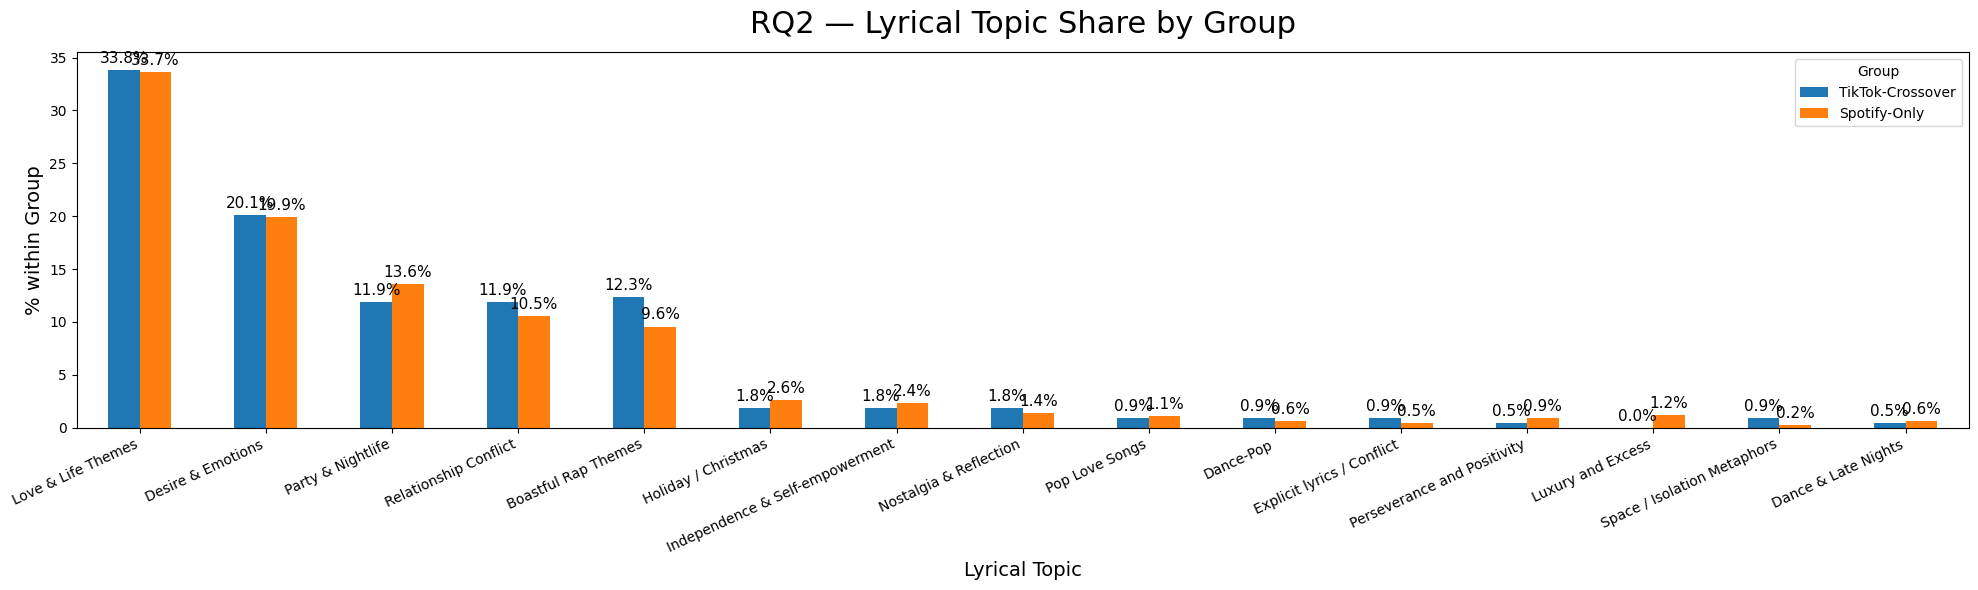

Saved figure → outputs/rq2_topics_bar_labels.png


In [9]:
# === RQ2 Final Plot (canonical keys + merged labels, safe filter version) ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, re

# ---------- canon helpers ----------
def canon_text(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.lower()
    s = re.sub(r"\([^)]*\)|\[[^\]]*\]", " ", s)  # remove parentheses/brackets
    s = re.sub(r"\b(feat|ft|with|x|&|and)\b", " ", s)
    s = re.sub(r"[^\w\s]", " ", s)              # punctuation → space
    s = re.sub(r"\s+", " ", s).strip()
    return s

def canon_artist(a: str) -> str:
    if not isinstance(a, str): return ""
    parts = re.split(r",|/|&|x|with|\+", a.lower())
    parts = [canon_text(p) for p in parts if p.strip()]
    return " ".join(parts[:2]).strip()

def build_key_canon(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    cols = {c.lower(): c for c in df.columns}
    if "title" not in cols and "track_name" in cols:
        df.rename(columns={cols["track_name"]: "title"}, inplace=True)
    if "artist" not in cols and "artist_name" in cols:
        df.rename(columns={cols["artist_name"]: "artist"}, inplace=True)
    if "artist" not in cols and "artists" in cols:
        df.rename(columns={cols["artists"]: "artist"}, inplace=True)
    if "key_canon" not in df.columns:
        df["key_canon"] = [
            f"{canon_text(t)} // {canon_artist(a)}"
            for t, a in zip(df.get("title", ""), df.get("artist", ""))
        ]
    return df

def canon_set(keys):
    out = set()
    for k in keys:
        if not isinstance(k, str): continue
        if " // " in k:
            t, a = k.split(" // ", 1)
            out.add(f"{canon_text(t)} // {canon_artist(a)}")
        else:
            out.add(canon_text(k))
    return out

# ---------- prepare topics ----------
topics_c = build_key_canon(topics.copy())

# drop unlabeled
unl_mask = (topics_c.get("topic_number", topics_c.get("topic", -2)) == -1) | (
    topics_c.get("topic_label", "").astype(str).str.lower().eq("unlabeled")
)
topics_c = topics_c.loc[~unl_mask].copy()

# one row per key
topic_assign = (
    topics_c.drop_duplicates(subset=["key_canon"], keep="first")
    .loc[:, ["key_canon", "topic_label", "topic" if "topic" in topics_c.columns else "topic_number"]]
    .rename(columns={"topic_number": "topic"})
)

# canonicalize both group sets
TIKTOK_CROSSOVER_CAN = canon_set(TIKTOK_CROSSOVER)
SPOTIFY_ONLY_CAN = canon_set(SPOTIFY_ONLY)

print(f"[info] group sizes → TikTok={len(TIKTOK_CROSSOVER_CAN)} | Spotify-only={len(SPOTIFY_ONLY_CAN)}")
print(f"[info] topics keys → {topic_assign['key_canon'].nunique()}")

# overlap diagnostics
ov_tik = topic_assign["key_canon"].isin(TIKTOK_CROSSOVER_CAN).sum()
ov_spo = topic_assign["key_canon"].isin(SPOTIFY_ONLY_CAN).sum()
print(f"[info] overlap     → TikTok={ov_tik} | Spotify-only={ov_spo}")

# ---------- compute shares ----------
def shares(keys_set, name):
    sub = topic_assign[topic_assign["key_canon"].isin(keys_set)]
    s = sub["topic"].value_counts(normalize=True) * 100.0
    s.name = name
    return s

tik_s = shares(TIKTOK_CROSSOVER_CAN, "TikTok-Crossover")
spo_s = shares(SPOTIFY_ONLY_CAN, "Spotify-Only")

plot_df = pd.concat([tik_s, spo_s], axis=1).fillna(0.0)

# map topic id → label
label_map = (
    topic_assign.drop_duplicates("topic")[["topic", "topic_label"]]
    .set_index("topic")["topic_label"]
    .to_dict()
)
plot_df.index = plot_df.index.map(label_map)

# merge duplicate labels
plot_df = plot_df.groupby(plot_df.index, as_index=True).sum()

# safe sort/filter/drop
plot_df["total"] = plot_df.sum(axis=1)
plot_df = plot_df.sort_values("total", ascending=False)
plot_df = plot_df.loc[plot_df["total"] >= 1.0]
plot_df = plot_df.drop(columns="total")

# ---------- plot ----------
if plot_df.empty:
    print("[warn] Nothing to plot — check overlaps or canonicalization.")
else:
    fig, ax = plt.subplots(figsize=(20, 6))
    plot_df.plot(kind="bar", ax=ax)
    ax.set_title("RQ2 — Lyrical Topic Share by Group", fontsize=22, pad=14)
    ax.set_xlabel("Lyrical Topic", fontsize=14)
    ax.set_ylabel("% within Group", fontsize=14)
    ax.legend(title="Group")

    for c in ax.containers:
        ax.bar_label(c, fmt="%.1f%%", padding=3, fontsize=11)

    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()

    os.makedirs("outputs", exist_ok=True)
    out_path = "outputs/rq2_topics_bar_labels.png"
    fig.savefig(out_path, dpi=300)
    print(f"Saved figure → {out_path}")









In [10]:
# === Caption and Quick Summary ===

print("Figure: RQ2 — Lyrical Topic Share by Group")
print("Caption: Distribution of lyrical topics among TikTok-Crossover and Spotify-Only songs.")
print("Both groups exhibit similar topic patterns dominated by Love & Life and Desire & Emotions,")
print("indicating that lyrical content does not strongly distinguish viral songs from those achieving")
print("traditional streaming success.")

print(f"\nCounts → TikTok-Crossover: {len(TIKTOK_CROSSOVER):,} | Spotify-Only: {len(SPOTIFY_ONLY):,}")
print("Source file: rq2_topics_bar_fuzzy_labels.csv")


Figure: RQ2 — Lyrical Topic Share by Group
Caption: Distribution of lyrical topics among TikTok-Crossover and Spotify-Only songs.
Both groups exhibit similar topic patterns dominated by Love & Life and Desire & Emotions,
indicating that lyrical content does not strongly distinguish viral songs from those achieving
traditional streaming success.

Counts → TikTok-Crossover: 260 | Spotify-Only: 2,811
Source file: rq2_topics_bar_fuzzy_labels.csv
